In [33]:
from ipywidgets import widgets, Layout
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz 
import math
from scipy.stats import norm

def plot_x(mu=1):
    w = np.linspace(0, 1, 100)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
  
    plt.grid(color='0.6')
    plt.plot(w,analytical_tpr(w,mu), c="tab:green")
    plt.plot([0,1], [0,1], "--k", label="random guessing")
    plt.title("Trade-off curve")

def analytical_tpr(fpr, mu):
    return 1-norm.cdf(norm.ppf(1-fpr)-mu)
    
def calc_privacy_lvl(C, tau, T, n, N, d):
    K = d
    n_eff = n + (n*n*tau*tau)/(C*C)
    mu_step = (d+(2*n-1)*K)/(n_eff*math.sqrt(2*d + 4*((n*n)/n_eff)*K))
    c = (n*math.sqrt(T))/N
    mu_tot =  c*fn_dong(mu_step)
    return mu_tot

def fn_dong(mus):
    return math.sqrt(2)*math.sqrt(math.exp(mus*mus)*norm.cdf(1.5*mus)+3*norm.cdf(-0.5*mus)-2)
def floater(C):
    try:
        C = math.inf if C == 'inf' else float(C)
    except ValueError:
        C = 1.0
    return C

def wrapper(C, tau, T, n, N, d):
    C = float(C)
    result = calc_privacy_lvl(C, tau, T, n, N, d)
    fpr_values = np.linspace(0, 1, 100)
    tpr_values = [analytical_tpr(fpr, result) for fpr in fpr_values]
    au_roc = trapz(tpr_values, fpr_values)
    tpr_at_001 = tpr_values[np.argmin(np.abs(fpr_values - 0.01))]
    tpr_at_005 = tpr_values[np.argmin(np.abs(fpr_values - 0.05))]
    ## Analycical acc = CDF(0.5*mu)
    acc = norm.cdf(0.5*result)
    display(HTML("<hr>"))
    display(Markdown(f"GMIP Privacy Level (mu): \t **{result:.3f}**"))
    display(Markdown(f"AU-ROC:\t **{au_roc:.3f}**"))
    display(Markdown(f"Accuracy: **{acc:.3f}**"))
    display(Markdown(f"TPR'@0.01: {tpr_at_001:.3f}"))
    display(Markdown(f"TPR'@0.05: {tpr_at_005:.3f}"))
    display(HTML("<hr>"))
    #print(f"GMIP Privacy Level (mu): {result}")
    #print(f"AU-ROC: {au_roc}")
    #print(f"TPR@0.01: {tpr_at_001}")
    #print(f"TPR@0.05: {tpr_at_005}")
    #print('Accuracy:', np.max(acc))
    
    fig, ax = plt.subplots()
    ax.plot(fpr_values, tpr_values, "tab:green", label='TPR vs. FPR')
    # ax.fill_between(fpr_values, tpr_values, color="tab:green", step='mid', alpha=0.4)
    ax.plot([0,1], [0,1], "--k", label="random guessing")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Trade-off Curve')
    ax.legend()
    fig.set_size_inches(3,3)
    plt.show()

style = {'description_width': 'initial'}
layout = {'width': '300px'}
C_widget = widgets.Text(value='inf', description='Cropping threshold (C):', style=style, layout=layout)
tau_widget = widgets.FloatText(value=0, description='Tau (Noise):', style=style, layout=layout)
T_widget = widgets.IntText(value=1200, description='T (SGD Steps):', style=style, layout=layout, continuous_update=True)
n_widget = widgets.IntText(value=400, description='n (Batch Size):', style=style, layout=layout, continuous_update=True)
N_widget = widgets.IntText(value=48000, description='N (Samples in Dataset):', style=style, layout=layout, continuous_update=True)
d_widget = widgets.IntText(value=650, description='d (Model Parameters):', style=style, layout=layout, continuous_update=True)

ui = widgets.VBox([
    widgets.HTML("<h3>How Membership Inference Private is Your Model?</h3>Enter your model's parameters to find out."),
    C_widget, tau_widget, T_widget, n_widget, N_widget, d_widget
])

out = widgets.interactive_output(wrapper, {'C': C_widget, 'tau': tau_widget, 'T': T_widget, 'n': n_widget, 'N': N_widget, 'd': d_widget})

display(ui, out)

Output()

In [43]:
C = 1.2
tau = [0.2, 0.3, 0.4]
T = 5
n = 64
N = 3000
d = 1000
res = []
for t in tau:
    res.append(calc_privacy_lvl(C, t, T, n, N, d))
# result = calc_privacy_lvl(C, tau, T, n, N, d)
fpr_values = np.linspace(0, 1, 100)
# tpr = [analytical_tpr(fpr_values, r) for r in res]
tpr = []
for r in res:
    tpr.append([analytical_tpr(fpr, r) for fpr in fpr_values])
# tpr_values = [analytical_tpr(fpr, result) for fpr in fpr_values]
# au_roc = trapz(tpr_values, fpr_values)
au_roc = [trapz(t, fpr_values) for t in tpr]
# tpr_at_001 = tpr_values[np.argmin(np.abs(fpr_values - 0.01))]
# tpr_at_005 = tpr_values[np.argmin(np.abs(fpr_values - 0.05))]
tpr_at_001 = [t[np.argmin(np.abs(fpr_values - 0.01))] for t in tpr]
tpr_at_005 = [t[np.argmin(np.abs(fpr_values - 0.05))] for t in tpr]

/var/folders/k9/sq1przdn1cv5sh7ty2xzg67w0000gn/T/ipykernel_5253/227172429.py:18: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  au_roc = [trapz(t, fpr_values) for t in tpr]


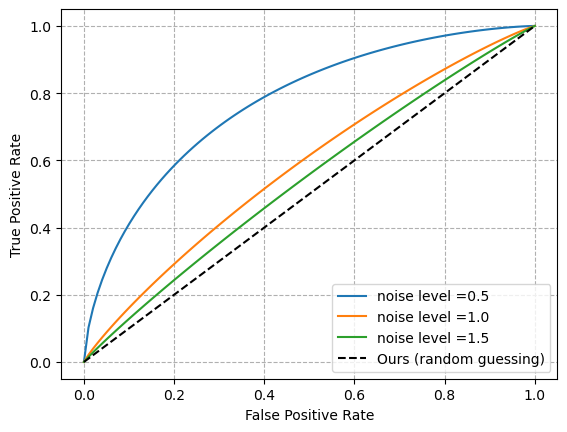

In [44]:

fig, ax = plt.subplots()
noise_level = [0.5, 1.0, 1.5]
for i in range(len(tau)):
    ax.plot(fpr_values, tpr[i], label=f'noise level ={noise_level[i]}')
ax.plot([0,1], [0,1], "--k", label="Ours (random guessing)")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.set_title('Trade-off Curve')
ax.legend()
ax.grid(True, which='both', linestyle='--')
# fig.set_size_inches(3,3)
# plt.title("MNIST")
plt.show()
# fig.savefig('tradeoff_curve2.png')

In [45]:
fig.savefig('tradeoff_curve2.png')